# Exploration des données

## Import & fonction

In [51]:
import pandas as pd
import numpy as np
import os
from pathlib import Path 
import missingno as msno
from tabulate import tabulate
from statistics import median, mean, quantiles
import pprint
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
import geopy.distance
import folium

plt.style.use('ggplot')
#pd.set_option('max_columns', 200)

## Fonction

In [38]:
# Création d'un DF pour afficher les stats des données
def tstats (data) :
    output = []
    for col in data.columns:
    
        nonNull  = len(data) - np.sum(pd.isna(data[col]))
        nonNullprop = (nonNull / len(data[col]))*100
        unique = data[col].nunique()
        colType = str(data[col].dtype)
        output.append([col, colType, nonNull, round(nonNullprop, 1) , unique])
            
    
    df_stats = pd.DataFrame(output)
    df_stats.columns = ['nom colonne','dtype', 'valeur non null',"% de non null", 'nb_unique']

    print(tabulate(df_stats, headers='keys', tablefmt='psql'))
    
    
def diff_in_hours (date1, date2) :
    result_hour = (date1 - date2) / pd.Timedelta('1 hour')
    return result_hour


def filter_brazil_data(longitudes, latitudes):
    filtered_longitudes = []
    filtered_latitudes = []
    for lon, lat in zip(longitudes, latitudes):
        if -74.5 <= lon <= -34.5 and -33.75 <= lat <= 5.5:
            filtered_longitudes.append(lon)
            filtered_latitudes.append(lat)
    return filtered_longitudes, filtered_latitudes


## Intégration des données et fusionner dans un dataframe

In [45]:
path = Path(os.getcwd()) 
p_parent = path.parent
p_customer = str(p_parent) + '\data\olist_customers_dataset.csv'
p_geo = str(p_parent) + '\data\olist_geolocation_dataset.csv'
p_order_item = str(p_parent) + '\data\olist_order_items_dataset.csv'
p_order_payment = str(p_parent) + '\data\olist_order_payments_dataset.csv'
p_order_review = str(p_parent) + '\data\olist_order_reviews_dataset.csv'
p_orders = str(p_parent) + '\data\olist_orders_dataset.csv'
p_products = str(p_parent) + '\data\olist_products_dataset.csv'
p_sellers = str(p_parent) + '\data\olist_sellers_dataset.csv'
p_category = str(p_parent) + '\data\product_category_name_translation_expanded.csv'

customer = pd.read_csv(p_customer)
geo = pd.read_csv(p_geo)
order_item = pd.read_csv(p_order_item)
order_payment = pd.read_csv(p_order_payment)
order_review = pd.read_csv(p_order_review)
orders = pd.read_csv(p_orders)
products = pd.read_csv(p_products)
sellers = pd.read_csv(p_sellers)
category = pd.read_csv(p_category)


#fusion avec .merge

df = orders.merge(customer, on="customer_id", how ='left')\
.merge(order_item, on= "order_id", how = 'left')\
.merge(order_payment, on ='order_id', how ='left')\
.merge(order_review, on ="order_id", how="left")\
.merge(sellers, on ='seller_id', how ="left")\
.merge(products, on = "product_id", how = 'left')\
.merge(category, on="product_category_name", how="left")

#les données géographiques sont trop volumineuse pour être integré dans le dataframe unique
#geo_seller = geo.rename(columns={"geolocation_zip_code_prefix":"seller_zip_code_prefix",
#                                 "geolocation_lat":"seller_lat",
#                                 "geolocation_lng":'seller_lng',
#                                 "geolocation_city": "seller_city",
#                                 "geolocation_state":"seller_state"})
#geo_customer = geo.rename(columns={"geolocation_zip_code_prefix":"customer_zip_code_prefix",
#                                   "geolocation_lat":"customer_lat",
#                                   "geolocation_lng":'customer_lng',
#                                   "geolocation_city": "customer_city",
#                                   "geolocation_state":"customer_state"})
#df = df.merge(geo_seller, on ="seller_zip_code_prefix", how ='left')
#df = df.merge(geo_customer, on ="customer_zip_code_prefix", how ='left')


#création d'un liste des nom de colonnes

cols = []

for col in df : 
    cols.append(col)

# transformation des colonnes date en format date

col_date = ['order_purchase_timestamp', 
            'order_approved_at', 
            'order_delivered_carrier_date', 
            'order_estimated_delivery_date',
            'review_creation_date',
            'review_answer_timestamp',
            'shipping_limit_date',
            'order_delivered_customer_date' 
           ]

# modification des type de colonne pour les zip code et les ID

df[col_date] = df[col_date].apply(pd.to_datetime)
df = df.astype({'customer_zip_code_prefix':'object',  'seller_zip_code_prefix' : 'object', "order_item_id": 'object'})

df= df.drop_duplicates()

tstats(df)

+----+-------------------------------+----------------+-------------------+-----------------+-------------+
|    | nom colonne                   | dtype          |   valeur non null |   % de non null |   nb_unique |
|----+-------------------------------+----------------+-------------------+-----------------+-------------|
|  0 | order_id                      | object         |            119143 |           100   |       99441 |
|  1 | customer_id                   | object         |            119143 |           100   |       99441 |
|  2 | order_status                  | object         |            119143 |           100   |           8 |
|  3 | order_purchase_timestamp      | datetime64[ns] |            119143 |           100   |       98875 |
|  4 | order_approved_at             | datetime64[ns] |            118966 |            99.9 |       90733 |
|  5 | order_delivered_carrier_date  | datetime64[ns] |            117057 |            98.2 |       81018 |
|  6 | order_delivered_custo

On peut voir que des traitements sont nécessaire sur les données :
- les dates ne sont pas au bon format

## Exploration des données

<AxesSubplot:>

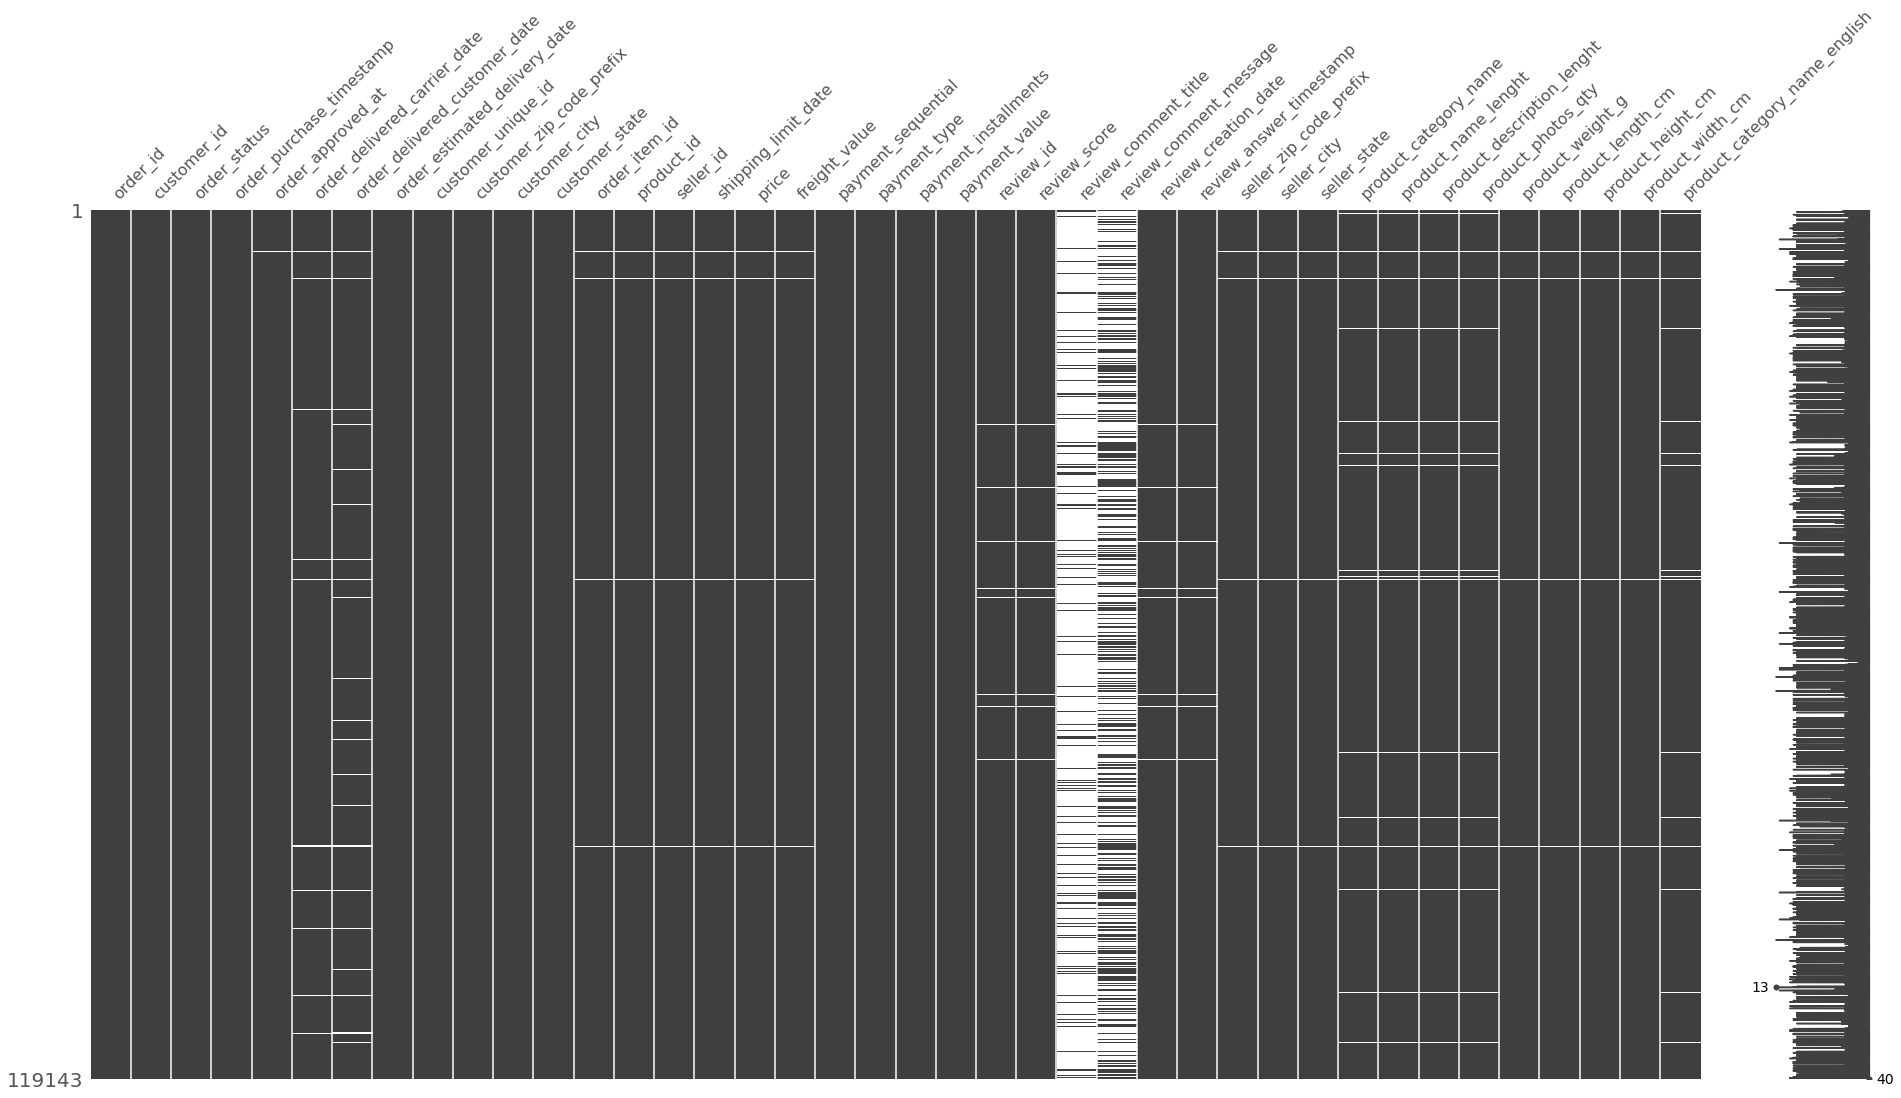

In [4]:
#Graph pour visualiser les NaN
msno.matrix(df, figsize=(32,16))

On peut voir que les champs sont relativement bien remplis a l'exeption de "review_comment_title" et "review_comment_message"

Certaines lignes semble également cumuler de nombreux NaN il faudrait investiguer un peu plus

<AxesSubplot:>

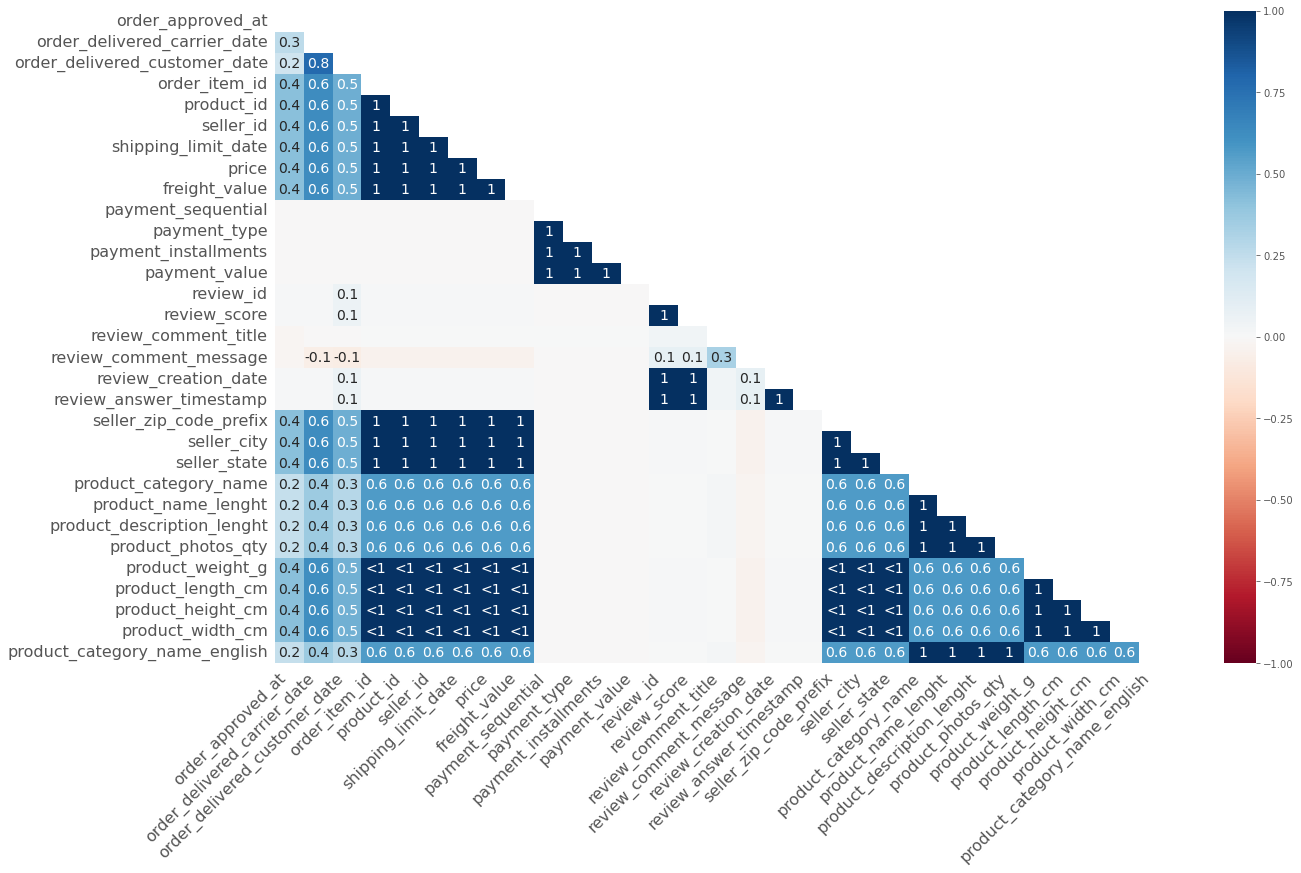

In [6]:
msno.heatmap(df)

La heatmap de msno montre les corrélations entre données manquantes. Un 1 indique que si un information manque dans une colonne, alors elle manquera également dans l'autre. Le -1 serait une anticorrélation.

On peut voir ici que lorsque order_delivered_customer_date est manquantes, order_delivered_carrier_date est souvent manquantes aussi.


## extraction des lignes suspectes

Cette étape a été désactivé après rectification des merges.

In [12]:
##créer une liste avec les nom des colonnes
#cols=[]
#for col in df.columns:
#    cols.append(col)
#
##stats des lignes avec des données manquantes : 
#df['number_of_NaNs'] = df[cols].isna().sum(1)
#df["number_of_NaNs"].describe()
#
###On voit que que pour plus de 75% des lignes, il y a que 2 données manquantes. Le maximum est à 26, ce qui représente plus de 50% des données manquantes sur une ligne. Il faut investiguer un peu plus pour déterminer cb de lignes sont concernées exactement et décider d'exclure ou non ces linges.
#number_of_NaNs = df.number_of_NaNs.value_counts().sort_index()
#print(number_of_NaNs)

##on voit que plusieurs centaines de lignes ont 20 ou + de donnée manquante sur leur ligne.
#high_nan_row = df[df['number_of_NaNs'] >= 20]
#msno.matrix(high_nan_row, figsize=(32,16))

##Parmis les lignes où il manque le plus de données on peut voir que ce sont les colonnes provenant des fichiers 
##
##- order_item.csv 
##- product.csv
##- sellers.csv
##
##Au vu des relations entre les table, le problème viens probablement de la jointure entre order et order_item sur order_id
##(product et sellers dépendent de order_item)

##La colonne order_status semble avoir des valeurs spécifiques

#high_nan_order_status = high_nan_row["order_status"].value_counts()
#df_order_status = df["order_status"].value_counts()
#ratio_order_status = high_nan_order_status /df_order_status *100

#df_stats_order_status = pd.concat([df_order_status, high_nan_order_status, ratio_order_status], axis=1)
#df_stats_order_status.columns = ['Order status_df', 'order_status_high_nan', 'ratio']
#df_stats_order_status.head()

##On peut voir que 98% des commandes qui ont le status 'unavailable' ont de nombreuses données manquantes, de meme que 24% des commandes 'canceled'
##
##Ces lignes pourronts être exclues si on cherche les 'bon clients', elle pourront éventuellement être prise en compte si on cherche les 'mauvais clients'
##
##Dans cette démarche on peurra étudier si des clients sont sur-représenté dans ces catégories  de "order status"

#client_bad_orderstatus = df[(df['order_status'] == "canceled") | (df['order_status'] == "unavailable")]
#client_bad_orderstatus = client_bad_orderstatus.value_counts("customer_id")

#client_bad_orderstatus = df[(df['order_status'] == "canceled") | (df['order_status'] == "unavailable")]
#client_bad_orderstatus_nb = client_bad_orderstatus.value_counts("customer_id")
#
#print(client_bad_orderstatus_nb)

#client_bad_orderstatus.head()

#print(client_bad_orderstatus["customer_id"])

##working on ....
#for bad_client in client_bad_orderstatus :
#    nb_command_total = 0
#    bc = bad_client["customer_id"]
#    for client in df:
#        if client["customer_id"] == bc :
#            nb_command_total += 1
#    client_bad_orderstatus["total_order"] = nb_command_total

### Nombre de commande par client

In [7]:
client_order = (df.groupby(['order_id', 'customer_unique_id'], as_index=False).count()
            .groupby('customer_unique_id')['order_id'].count())
print(client_order.value_counts().sort_index())

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
9         1
17        1
Name: order_id, dtype: int64


On peut voir que la majorité des clients ont commandé qu'une fois. Il faudrait sans doute analyser les clients ayant commandé de multiples fois séparément.

### Nombre de review par client

In [8]:
client_review = (df.groupby(['customer_unique_id', 'review_id'], as_index=False).count()
            .groupby('customer_unique_id')['review_id'].count())
print(client_review.value_counts().sort_index())

1     92659
2      2503
3       172
4        28
5         7
6         6
7         3
8         1
17        1
Name: review_id, dtype: int64


On peut voir que la majorité des clients n'ont laissé qu'une review. 

## Nombre group by Customer

In [9]:
gr_customer = df.groupby(['customer_unique_id'], as_index=False).aggregate({
                'customer_unique_id' : 'nunique',
                'order_id':'nunique',
                'price' : 'sum',
                'review_id':'nunique',
                'review_score':'mean',
                'product_id' : 'count',
                'seller_id' : 'nunique'
                })

round(gr_customer.describe())

,customer_unique_id,order_id,price,review_id,review_score,product_id,seller_id
count,96096.0,96096.0,96096.0,96096.0,95380.0,96096.0,96096.0
mean,1.0,1.0,149.0,1.0,4.0,1.0,1.0
std,0.0,0.0,249.0,0.0,1.0,1.0,0.0
min,1.0,1.0,0.0,0.0,1.0,0.0,0.0
25%,1.0,1.0,48.0,1.0,4.0,1.0,1.0
50%,1.0,1.0,90.0,1.0,5.0,1.0,1.0
75%,1.0,1.0,160.0,1.0,5.0,1.0,1.0
max,1.0,17.0,13440.0,17.0,5.0,75.0,10.0


Les 96096 clients ont chacun :
- réalisé entre 1 et 17 commande, 
- pour un total de 1 à 75 produits
- chez 0 à 10 vendeurs différents
- dépensé un montant compris entre 0 et 13440, 
- laissé entre 0 et 17 review 
- avec une moyenne comprise entre 1 et 5

## Nombre group by Category

In [47]:
gr_category = df.groupby(['metacategory']).aggregate({
    
    'price' : 'sum',
    'customer_unique_id' : 'nunique',
    'review_id':'nunique',
    'review_score':'mean',
    'order_id':'nunique',
    'order_item_id' :'count',
    'product_id' : 'count',
    'seller_id' : 'nunique'
    })


print(gr_category.sort_values(by=['price'], ascending =False ))

                        price  customer_unique_id  review_id  review_score  \
metacategory                                                                 
Home supply        4312839.25               30875      31469      3.959494   
Health and beauty  2153403.51               14654      14799      4.109266   
High tech          1986695.73               15065      15173      3.958899   
Other              1876610.87               11965      12008      4.118235   
Fashion            1402743.88                6574       6612      4.061749   
Sport supply       1029603.88                7515       7656      4.107470   
Tools               362647.91                1924       1921      4.035788   
Books               156215.13                 998       1002      4.359266   
Food and Drinks      69505.72                 961        967      4.192405   
Art                   6961.26                  65         66      4.216216   

                   order_id  order_item_id  product_id  seller_

On peut voir que les catégories ayant généré le plus de ventes sont : 
 - health_beauty :
     - 2153403.51 de revenu 
     - 14897 commande
     - 14654 clients différents 
     -16864 produits au total 
     -784 vendeurs différents
     -14799 reviews à 4.1 de moyenne, 

In [242]:
### Exploration valeur numérique
###a voir la pertinance


#   df_num= df.select_dtypes(include=["int64", "float64"])
#   #df_num.drop(columns=['customer_zip_code_prefix', 'seller_zip_code_prefix', "order_item_id"], inplace = True)
#   output = []
#   for col in df_num.columns:
#   
#       nonNull  = len(df) - np.sum(pd.isna(df[col]))
#       nonNullprop = (nonNull / len(df[col]))*100
#       unique = df[col].nunique()
#       colType = str(df[col].dtype)
#       min = np.min(df[col])
#       max = np.max(df[col])
#       moyenne = round(np.nanmean(df[col]),2)
#       quantile25 = np.nanquantile(df[col],0.25)
#       quantile5 = np.nanquantile(df[col],0.5)
#       quantile75 = np.nanquantile(df[col],0.5)
#       std = round(np.nanstd(df[col]),2)
#       var = round(np.nanvar(df[col]),2)
#       output.append([col, min, max, quantile25, quantile5, quantile75, std, var]) 
#           
#   df_stats = pd.DataFrame(output)
#   df_stats.columns = ['nom colonne', "min", "max", 'quantile.25', 'median', 'quantile.75', 'std', 'var']
#   
#   
#   pp = pprint.PrettyPrinter(indent=4)
#   #print(tabulate(df_stats, headers='keys', tablefmt='psql'))
#   pp.pprint(df_stats)

In [12]:
#   review_score_heatmap = df.corr()['review_score'].to_frame().sort_values('review_score', ascending=False)
#   review_score_heatmap = review_score_heatmap.drop(['review_score'])
#   sns.heatmap(review_score_heatmap, annot=True)
#   plt.title("Order_ID Correaltions to Review Score")
#   plt.show()

In [13]:
#  sns.pairplot(df)

# Feature Engineering

Dans cette partie, nous allons créer de nouvelles variables à partir des données de base qui pourront nous aider a mieux comprendre les différents comportement des clients.

## Date features 

### Buying frequency

In [36]:
# Ordrer the data set by customer ID and Ordering date: 
df = df.sort_values(by=['customer_unique_id', 'order_purchase_timestamp'])

# Calcul of time diff between 2 successive order :
df['buy_date_diff'] = df.groupby('customer_unique_id')['order_purchase_timestamp'].diff()

# Convert into days and set to 0 all the customer who only ordered once
df['buy_freq'] = df['buy_date_diff'].dt.days
df['buy_freq'] = df['buy_freq'].fillna(0)

# group by to get the average frequency per customer

avg_buy_freq = df.groupby('customer_unique_id')['buy_freq']\
    .mean().reset_index()\
    .rename(columns={'buy_freq': 'Avg Buying Frequency'})

# the result is the average number of days between 2 order for a customer.
avg_buy_freq.describe()

,Avg Buying Frequency
count,96096.000000
mean,1.121853
std,10.847308
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,304.000000


In [13]:
df["tapproved"] = diff_in_hours(df['order_approved_at'], df['order_purchase_timestamp'])
df['testimate'] = diff_in_hours(df['order_estimated_delivery_date'], df['order_delivered_customer_date'])
df['totaltime'] = diff_in_hours(df['order_delivered_customer_date'], df['order_purchase_timestamp'])
df['treview'] =  diff_in_hours(df['review_creation_date'], df['order_delivered_customer_date'])

### Transport feature

In [18]:
#Du ratio du prix lié au transport
df['ratio_transport_cost'] = df["price"] / df["freight_value"]

# Customer Focus: 

In [14]:
gr_customer = df.groupby(['customer_unique_id'], as_index=False).aggregate({
                'order_id':'nunique',
                'price' : 'sum',
                'review_id':'nunique',
                'review_score':'mean',
                'product_id' : 'count',
                'seller_id' : 'nunique',
                'tapproved' : 'mean',
                'testimate' : 'mean',
                'totaltime' : 'mean',
                'treview' : 'mean'
                }).rename(columns={"customer_unique_id": "customer_unique_id",
                            "order_id": "nb_order",
                            "price": "total_spend", 
                            "review_id" : "nb_review", 
                            "review_score": "mean_review", 
                            "product_id": "total_nb_product", 
                            "seller_id": "total_nb_sellers",
                            "tapproved": "temps_approbation",
                            "testimate": "erreur_estimation_livraison",
                            "totaltime": "temps_commande_livraison",
                            "treview": "temps_livraison_review"}) 


print(gr_customer)

                     customer_unique_id  nb_order  total_spend  nb_review  \
0      0000366f3b9a7992bf8c76cfdf3221e2         1       129.90          1   
1      0000b849f77a49e4a4ce2b2a4ca5be3f         1        18.90          1   
2      0000f46a3911fa3c0805444483337064         1        69.00          1   
3      0000f6ccb0745a6a4b88665a16c9f078         1        25.99          1   
4      0004aac84e0df4da2b147fca70cf8255         1       180.00          1   
...                                 ...       ...          ...        ...   
96091  fffcf5a5ff07b0908bd4e2dbc735a684         1      1570.00          1   
96092  fffea47cd6d3cc0a88bd621562a9d061         1        64.89          1   
96093  ffff371b4d645b6ecea244b27531430a         1        89.90          1   
96094  ffff5962728ec6157033ef9805bacc48         1       115.00          1   
96095  ffffd2657e2aad2907e67c3e9daecbeb         1        56.99          1   

       mean_review  total_nb_product  total_nb_sellers  temps_approbation  

<AxesSubplot:>

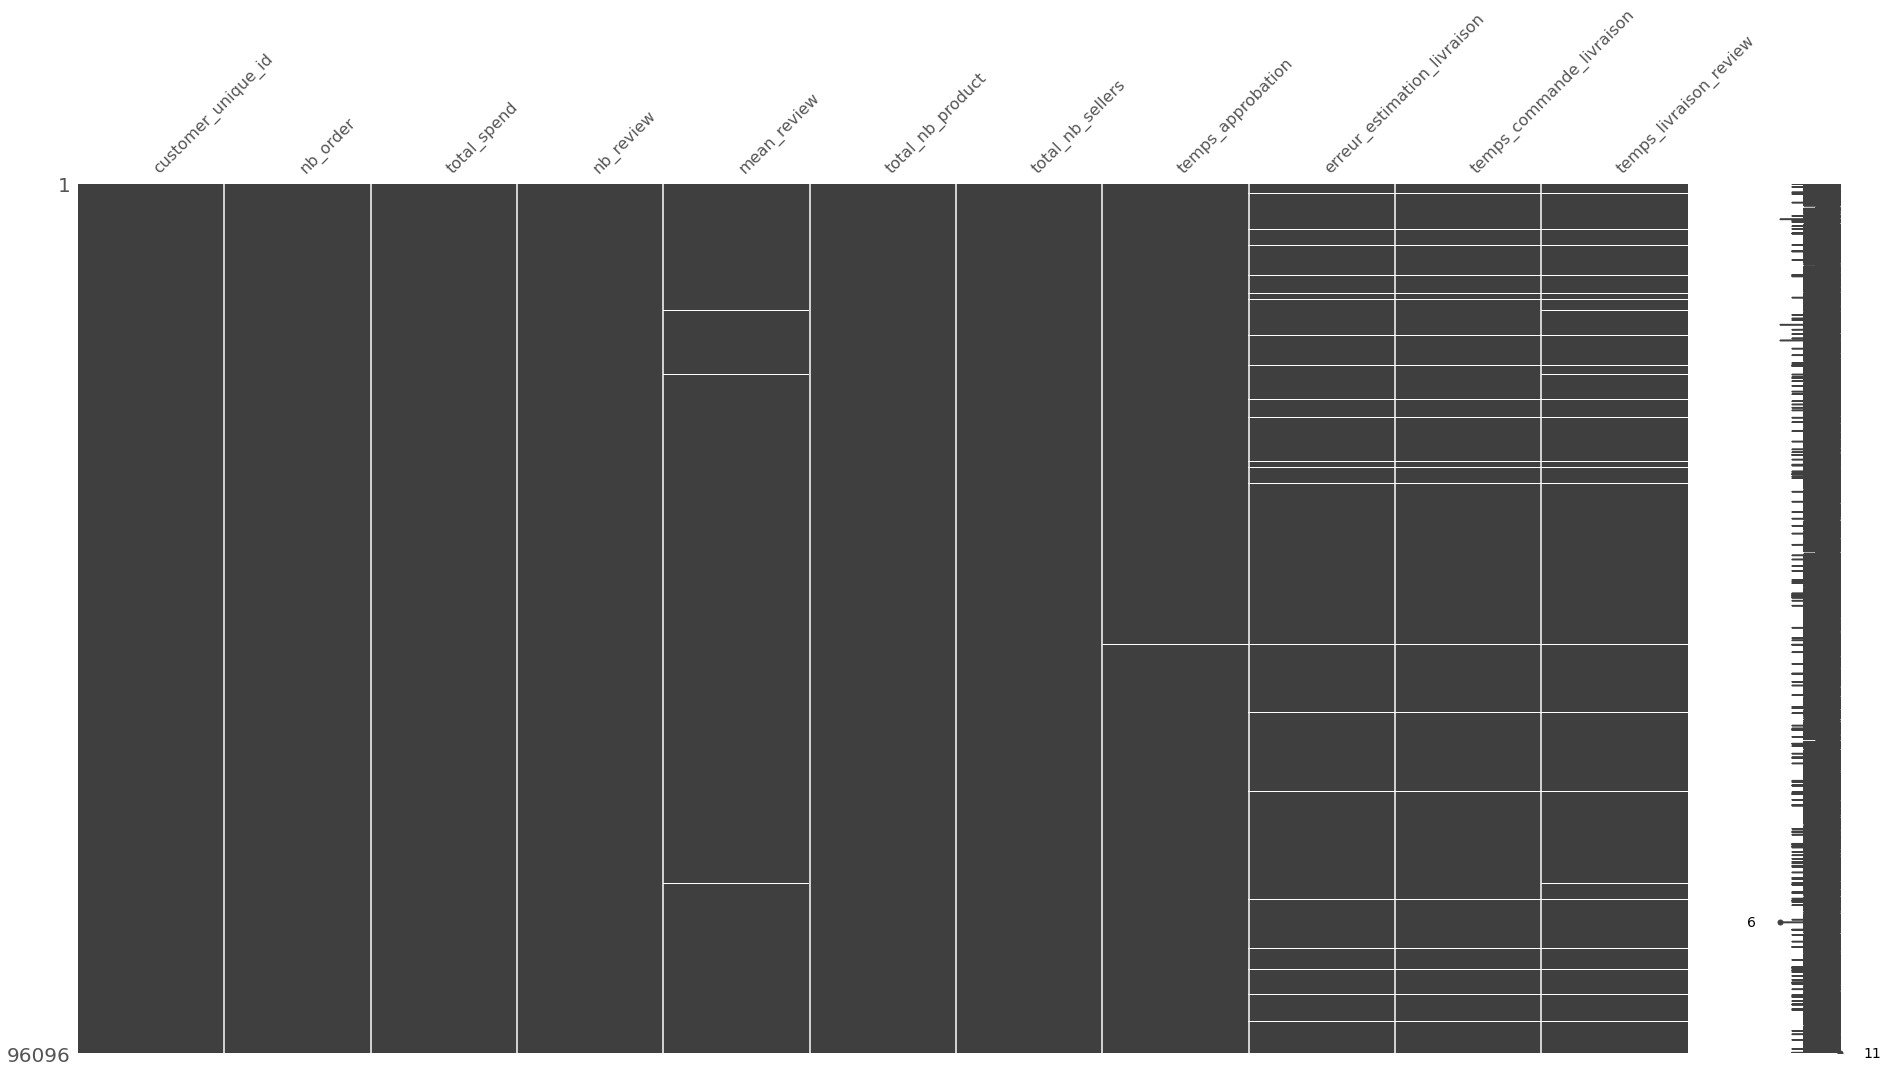

In [15]:
msno.matrix(gr_customer, figsize=(32,16))

In [343]:
gr_customer= gr_customer.dropna()

In [348]:
kmeans = KMeans(n_clusters=5)
gr_customer['mean_review'] = kmeans.fit_predict(gr_customer[['total_spend',
                                                    'temps_approbation', 
                                                    'erreur_estimation_livraison', 
                                                    'temps_commande_livraison', 
                                                    'temps_livraison_review']])

C:\Users\Panah\AppData\Local\Temp\ipykernel_23472\185042562.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gr_customer['mean_review'] = kmeans.fit_predict(gr_customer[['total_spend',


In [ ]:
# examine each cluster and try to understand what characterizes customers in each group
cluster_analysis = df.groupby('cluster').agg({
    'total_spent': 'mean',
    'average_order_value': 'mean',
    'frequency': 'mean'
})
print(cluster_analysis)